## Stage 3: CNN Classifier
The manual approach, yielded some positive results
Let's see if a machine learning algorithm using just the spectrogram information might also work

In [10]:
# imports and constants
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from scipy.io.wavfile import read as read_wav
from scipy import fft,signal
from sklearn.preprocessing import minmax_scale
import warnings
from tqdm import tqdm
import tensorflow_io as tfio

A_FREQ = 440 
NOTES = ['A','A#','B','C','C#','D','D#','E','F','F#','G','G#'] 

In [11]:
# try it out on a few of the files in /data/train_set.csv:
train_set = pd.read_csv('data/train_set.csv')
test_set = pd.read_csv('data/test_set.csv')
print(train_set.head())

# remove the chords that are not maj, min, dim or aug in the Quality column
train_set = train_set[train_set['Quality'].isin(['maj', 'min', 'dim', 'aug'])]
test_set = test_set[test_set['Quality'].isin(['maj', 'min', 'dim', 'aug'])]

                                    File Path Root Note  Octave Quality  \
0        data/chords/dim/Eb-7-dim-chord-1.wav        Eb       7     dim   
1   data/chords/min7b5/C-3-min7b5-chord-1.wav         C       3  min7b5   
2       data/chords/dim7/E-6-dim7-chord-0.wav         E       6    dim7   
3        data/chords/min/Bb-5-min-chord-0.wav        Bb       5     min   
4  data/chords/maj7_2/Ab-5-maj7_2-chord-0.wav        Ab       5  maj7_2   

   Inversion  
0          1  
1          1  
2          0  
3          0  
4          0  


In [12]:
import numpy as np
import scipy.io.wavfile as wav
import scipy.signal as signal

scheme = ["min", "maj", "dim", "aug"]

def load_wav_16k_mono(filename):
    sample_rate, wav_data = wav.read(filename)
    if wav_data.ndim > 1:
        wav_data = wav_data[:, 0]
    return wav_data, sample_rate

def preprocess(file_path, label):
    wav_data, sample_rate = load_wav_16k_mono(file_path)
    wav_data = wav_data[:48000]
    zero_padding = np.zeros(48000 - len(wav_data), dtype=np.float32)
    wav_data = np.concatenate([zero_padding, wav_data])
    spectrogram = np.abs(signal.stft(wav_data, nperseg=320, noverlap=288)[2])
    
    # Add an extra dimension to the spectrogram before resizing
    spectrogram = tf.expand_dims(spectrogram, axis=-1)
    
    # Ensure the spectrogram has the correct dimensions
    spectrogram = tf.image.resize(spectrogram, [300, 500])

    # set the one-hot encoding of the label
    quality_one_hot = [0,0,0,0]
    for i in range(len(scheme)):
        if scheme[i] == label:
            quality_one_hot[i] = 1

    return spectrogram, quality_one_hot


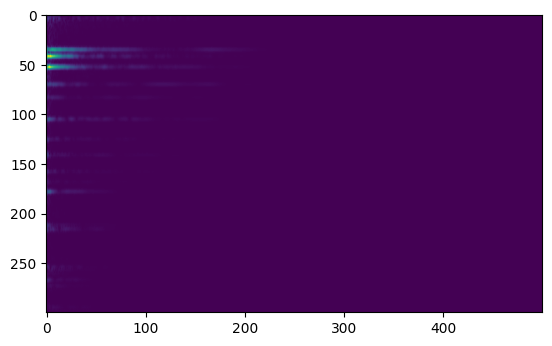

In [13]:
spectrogram, label = preprocess(train_set['File Path'].iloc[1], train_set['Quality'].iloc[1])
plt.imshow(spectrogram)
plt.show()

In [14]:


# Assuming train_set is your DataFrame
file_paths = train_set['File Path'].to_numpy()
qualities = train_set['Quality'].to_numpy()

# Create a dataset using from_generator
def generator():
    for file_path, quality in zip(file_paths, qualities):
        spectrogram, quality_one_hot = preprocess(file_path, quality)
        spectrogram = tf.expand_dims(spectrogram, axis=0)
        quality_one_hot = tf.expand_dims(quality_one_hot, axis=0)


        yield spectrogram, tf.convert_to_tensor(np.array(quality_one_hot), dtype=tf.float32)

dataset = tf.data.Dataset.from_generator(generator, output_signature=(
    tf.TensorSpec(shape=(None, 161, 1501, 1), dtype=tf.float32),
    tf.TensorSpec(shape=(None,4), dtype=tf.float32)
))


In [15]:
train_set['File Path'] = train_set['File Path'].str.replace('#', 's')
test_set['File Path'] = test_set['File Path'].str.replace('#', 's')

In [16]:
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPooling2D

file_paths = train_set['File Path'].to_numpy()
qualities = train_set['Quality'].to_numpy()

# Create a dataset using from_generator
def generator():
    for file_path, quality in zip(file_paths, qualities):
        spectrogram, quality_one_hot = preprocess(file_path, quality)
        spectrogram = tf.expand_dims(spectrogram, axis=0)
        quality_one_hot = tf.expand_dims(quality_one_hot, axis=0)

        yield spectrogram, tf.convert_to_tensor(np.array(quality_one_hot), dtype=tf.float32)

dataset = tf.data.Dataset.from_generator(generator, output_signature=(
    tf.TensorSpec(shape=(None, 300, 500, 1), dtype=tf.float32),
    tf.TensorSpec(shape=(None,4), dtype=tf.float32)
))

train_dataset = dataset.take(int(0.8 * 713))
val_dataset = dataset.skip(int(0.8 * 713))

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(300, 500, 1)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dropout(0.5))  # Adjust the dropout rate as needed
model.add(Dense(4, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with a validation set
history = model.fit(
    train_dataset,
    epochs=10, batch_size=32,
    validation_data=val_dataset
)

Epoch 1/10
570/570 [==============================] - 49s 86ms/step - loss: 6.5623 - accuracy: 0.2316 - val_loss: 1.3880 - val_accuracy: 0.2168
Epoch 2/10
570/570 [==============================] - 49s 87ms/step - loss: 1.4131 - accuracy: 0.2789 - val_loss: 1.3903 - val_accuracy: 0.1958
Epoch 3/10
570/570 [==============================] - 49s 86ms/step - loss: 1.3901 - accuracy: 0.3018 - val_loss: 1.4243 - val_accuracy: 0.1888
Epoch 4/10
570/570 [==============================] - 50s 87ms/step - loss: 1.3402 - accuracy: 0.3474 - val_loss: 1.4401 - val_accuracy: 0.1888
Epoch 5/10
570/570 [==============================] - 50s 87ms/step - loss: 1.2890 - accuracy: 0.3930 - val_loss: 1.4576 - val_accuracy: 0.1958
Epoch 6/10
570/570 [==============================] - 52s 91ms/step - loss: 1.2795 - accuracy: 0.3807 - val_loss: 1.4366 - val_accuracy: 0.1678
Epoch 7/10
570/570 [==============================] - 51s 89ms/step - loss: 1.3092 - accuracy: 0.4088 - val_loss: 1.4654 - val_accuracy:

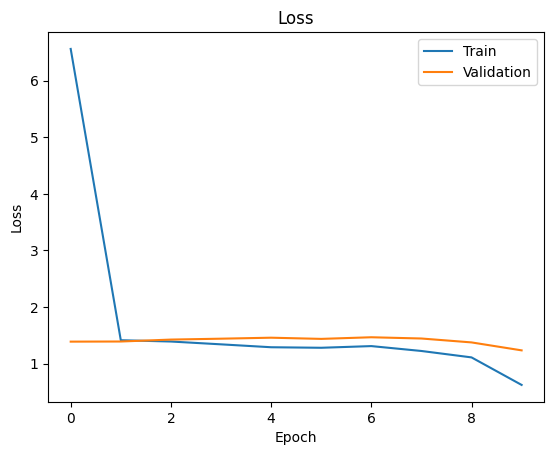

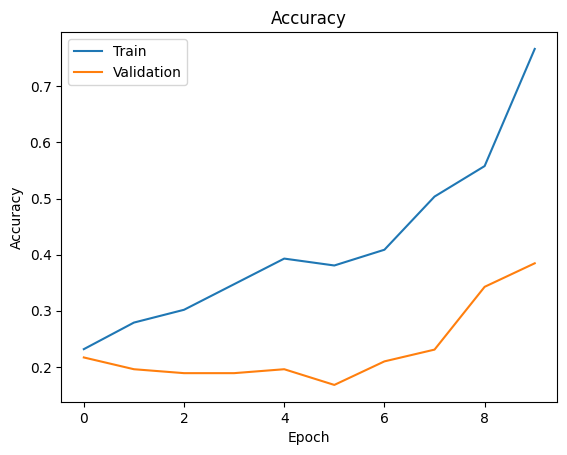

In [17]:
# make a plot of the training and validation loss and accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()


In [18]:
# test the model on the test_set

file_paths = test_set['File Path'].to_numpy()
qualities = test_set['Quality'].to_numpy()

# Create a dataset using from_generator
def test_generator():
    for file_path, quality in zip(file_paths, qualities):
        spectrogram, quality_one_hot = preprocess(file_path, quality)
        spectrogram = tf.expand_dims(spectrogram, axis=0)
        quality_one_hot = tf.expand_dims(quality_one_hot, axis=0)

        yield spectrogram, tf.convert_to_tensor(np.array(quality_one_hot), dtype=tf.float32)

test_dataset = tf.data.Dataset.from_generator(test_generator, output_signature=(
    tf.TensorSpec(shape=(None, 300, 500, 1), dtype=tf.float32),
    tf.TensorSpec(shape=(None,4), dtype=tf.float32)
))


test_loss, test_accuracy = model.evaluate(test_dataset)
print('Test loss: {0:.2f}. Test accuracy: {1:.2f}%'.format(test_loss, test_accuracy*100.))

307/307 [==============================] - 5s 15ms/step - loss: 1.3125 - accuracy: 0.4007
Test loss: 1.31. Test accuracy: 40.07%
